In [1]:
import numpy as np 
import pandas as pd 
import random
import os
from pathlib import Path
import tensorflow as tf
from random import randint
from tensorflow import keras
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
from tensorflow.keras.layers import Conv2D, Flatten
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from distutils.dir_util import copy_tree, remove_tree
from sklearn.metrics import balanced_accuracy_score as BAS
from tensorflow.keras.applications.resnet50 import ResNet50 
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.applications.inception_v3 import InceptionV3
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, MaxPool2D, GlobalAveragePooling2D

In [3]:
tf.random.set_seed(42)
random.seed(42)

In [4]:
EPOCHS = 100
BATCH_SIZE = 32
IMG_SIZE = 128
IMAGE_SIZE = [128, 128]
DIM = (IMG_SIZE, IMG_SIZE)

In [5]:
train_dir = Path('/kaggle/input/best-alzheimer-mri-dataset-99-accuracy/Combined Dataset/train/')
filepaths = list(train_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [6]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

In [7]:
train_df = pd.concat([filepaths, labels], axis=1)

In [8]:
train_df = train_df.sample(frac=1).reset_index(drop = True)

In [9]:
train_df.head()

,Filepath,Label
0,/kaggle/input/best-alzheimer-mri-dataset-99-ac...,No Impairment
1,/kaggle/input/best-alzheimer-mri-dataset-99-ac...,Moderate Impairment
2,/kaggle/input/best-alzheimer-mri-dataset-99-ac...,Moderate Impairment
3,/kaggle/input/best-alzheimer-mri-dataset-99-ac...,Mild Impairment
4,/kaggle/input/best-alzheimer-mri-dataset-99-ac...,Moderate Impairment


In [10]:
test_dir = Path('/kaggle/input/best-alzheimer-mri-dataset-99-accuracy/Combined Dataset/test')

In [11]:
filepaths = list(test_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')


In [12]:
test_df = pd.concat([filepaths, labels], axis=1)
test_df = test_df.sample(frac=1).reset_index(drop = True)

In [13]:
test_df.head()

,Filepath,Label
0,/kaggle/input/best-alzheimer-mri-dataset-99-ac...,No Impairment
1,/kaggle/input/best-alzheimer-mri-dataset-99-ac...,No Impairment
2,/kaggle/input/best-alzheimer-mri-dataset-99-ac...,No Impairment
3,/kaggle/input/best-alzheimer-mri-dataset-99-ac...,Very Mild Impairment
4,/kaggle/input/best-alzheimer-mri-dataset-99-ac...,No Impairment


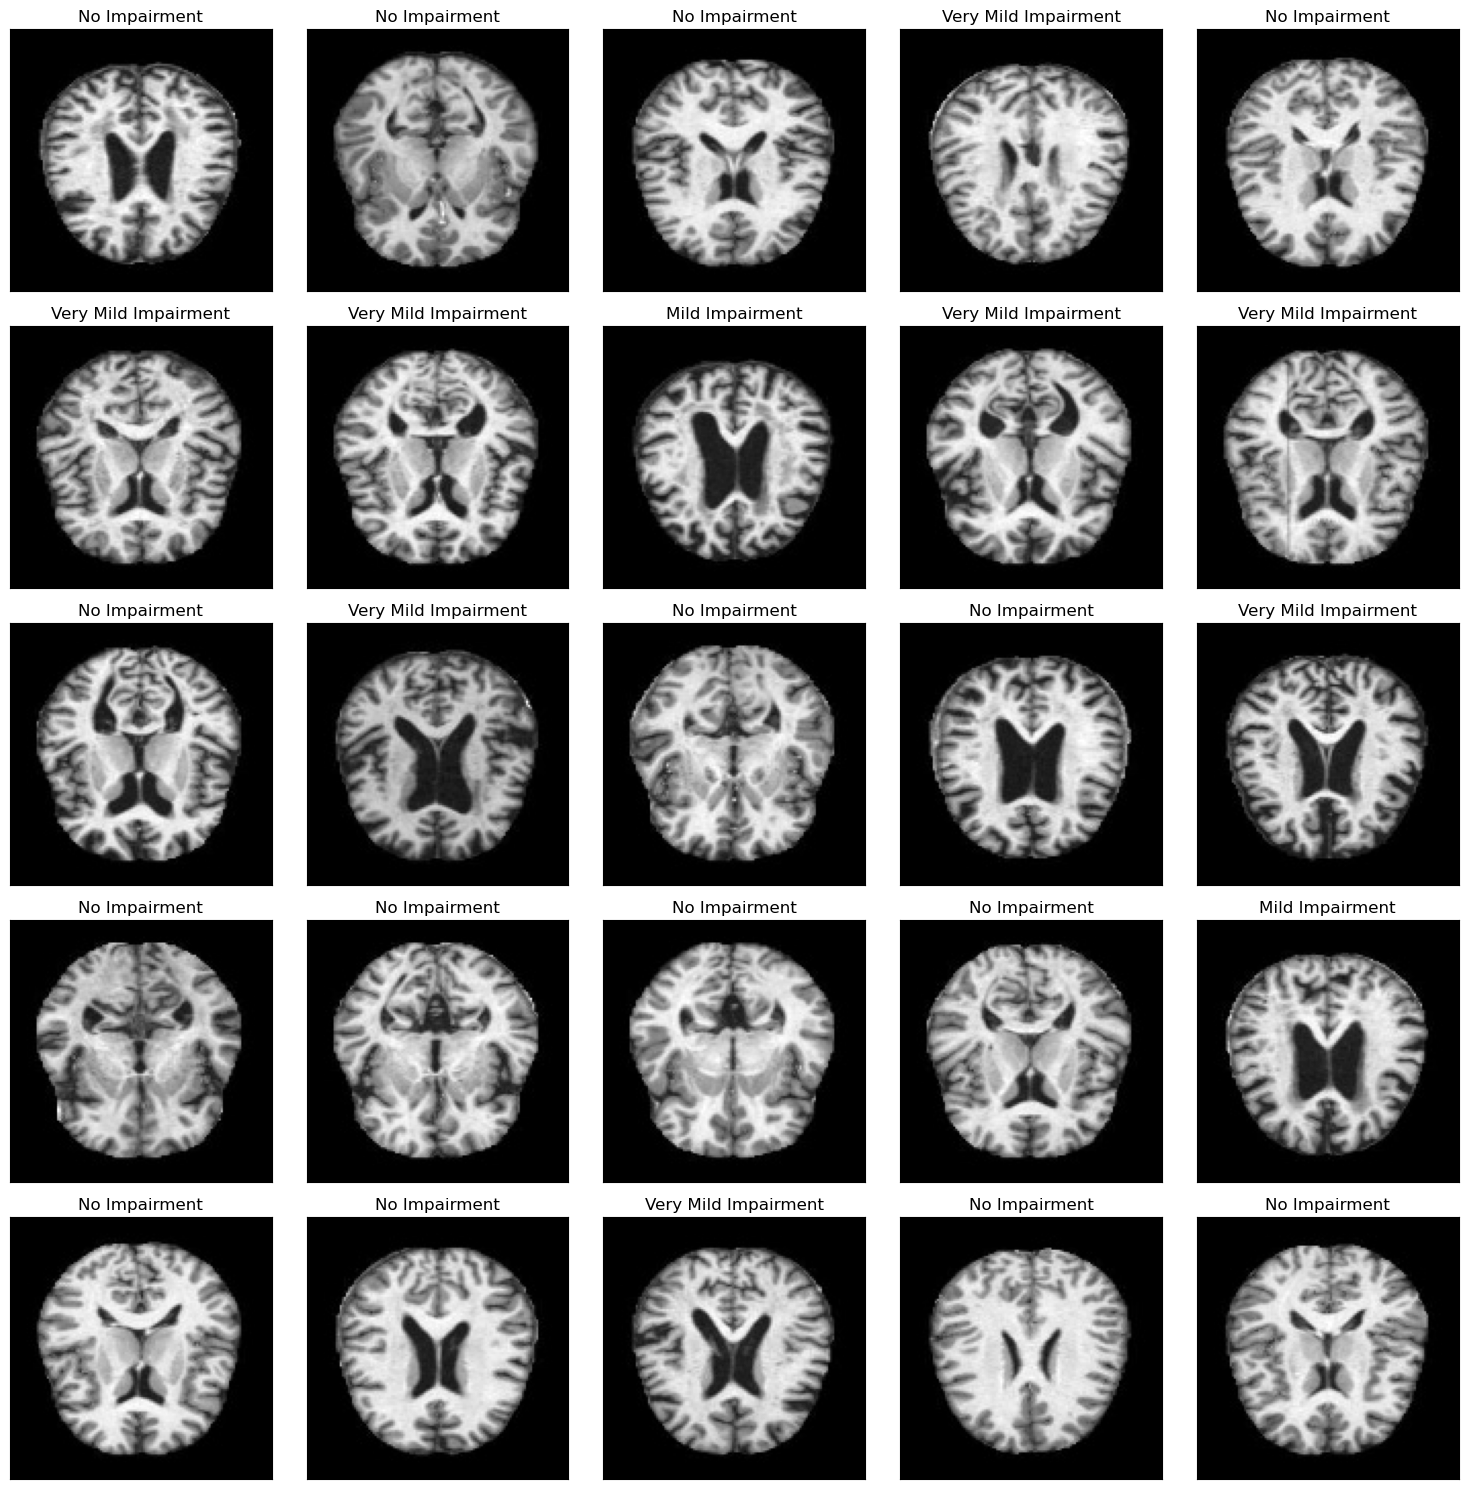

In [14]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath[i]), cmap='gray')
    ax.set_title(test_df.Label[i])
plt.tight_layout()
plt.show()


In [15]:
from tensorflow import keras
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Dropout

In [16]:
custom_model_combined = Sequential([
    Input(shape=(*IMAGE_SIZE, 3)),
    Conv2D(16, 3, activation='relu', padding='same'),
    Conv2D(16, 3, activation='relu', padding='same'),
    MaxPool2D(),
    Conv2D(32, 3, activation='relu', padding='same'),
    Conv2D(32, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(),
    Conv2D(64, 3, activation='relu', padding='same'),
    Conv2D(64, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(),
    Conv2D(128, 3, activation='relu', padding='same'),
    Conv2D(128, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(),
    Conv2D(256, 3, activation='relu', padding='same'),
    Conv2D(256, 3, activation='relu', padding='same', name = 'last_conv_layer'),
    BatchNormalization(),
    MaxPool2D(),
    Flatten(),
    Dropout(0.2),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.7),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(4, activation='softmax')        
], name = "cnn_model")

custom_model_combined.summary(line_length=100)


Model: "cnn_model"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 conv2d (Conv2D)                             (None, 128, 128, 16)                    448            
                                                                                                    
 conv2d_1 (Conv2D)                           (None, 128, 128, 16)                    2320           
                                                                                                    
 max_pooling2d (MaxPooling2D)                (None, 64, 64, 16)                      0              
                                                                                                    
 conv2d_2 (Conv2D)                           (None, 64, 64, 32)                      4640           
                                                                        

In [17]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1.0/255.0)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1.0/255.0)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(128,128),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    seed = 5638,
    shuffle=False
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(128, 128),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    seed = 5638,
    shuffle=False
)

Found 10240 validated image filenames belonging to 4 classes.
Found 1279 validated image filenames belonging to 4 classes.


In [18]:
OPT = tf.keras.optimizers.Adam(learning_rate=0.001)

METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'), 
           tfa.metrics.F1Score(num_classes=4)]

custom_model_combined.compile(optimizer='adam',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)

In [19]:
earlystopping = EarlyStopping(monitor = 'val_loss', 
                              mode = 'min', 
                              patience = 10,
                              verbose = 1)

filepath = './best_weights.hdf5'

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_loss', 
                                mode='min', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [20]:
custom_model_combined_history = custom_model_combined.fit(train_images,validation_data=test_images, callbacks=callback_list, epochs=EPOCHS)

Epoch 1/100
320/320 [==============================] - ETA: 0s - loss: 1.1714 - acc: 0.5163 - auc: 0.7803 - f1_score: 0.5113
Epoch 1: val_loss improved from inf to 4.22593, saving model to ./best_weights.hdf5
320/320 [==============================] - 54s 116ms/step - loss: 1.1714 - acc: 0.5163 - auc: 0.7803 - f1_score: 0.5113 - val_loss: 4.2259 - val_acc: 0.5004 - val_auc: 0.5819 - val_f1_score: 0.1668
Epoch 2/100
319/320 [============================>.] - ETA: 0s - loss: 0.6331 - acc: 0.7188 - auc: 0.9283 - f1_score: 0.7187
Epoch 2: val_loss did not improve from 4.22593
320/320 [==============================] - 17s 53ms/step - loss: 0.6331 - acc: 0.7188 - auc: 0.9283 - f1_score: 0.7187 - val_loss: 8.1278 - val_acc: 0.5004 - val_auc: 0.6669 - val_f1_score: 0.1668
Epoch 3/100
320/320 [==============================] - ETA: 0s - loss: 0.5392 - acc: 0.7692 - auc: 0.9485 - f1_score: 0.7705
Epoch 3: val_loss improved from 4.22593 to 1.43409, saving model to ./best_weights.hdf5
320/320 [==

In [21]:
CLASSES = list(test_images.class_indices.keys())

In [22]:
test_scores = custom_model_combined.evaluate(test_images)
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))
pred_labels = custom_model_combined.predict(test_images)

def roundoff(arr):
    """To round off according to the argmax of each predicted label array."""
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)
    
pred = np.argmax(pred_labels,axis=1)

print(classification_report(test_images.classes,pred,target_names=CLASSES))

40/40 [==============================] - 2s 42ms/step - loss: 0.1785 - acc: 0.9507 - auc: 0.9900 - f1_score: 0.9629
Testing Accuracy: 95.07%
40/40 [==============================] - 2s 39ms/step
                      precision    recall  f1-score   support

     Mild Impairment       0.98      0.93      0.96       179
 Moderate Impairment       1.00      1.00      1.00        12
       No Impairment       0.92      0.99      0.96       640
Very Mild Impairment       0.98      0.90      0.94       448

            accuracy                           0.95      1279
           macro avg       0.97      0.96      0.96      1279
        weighted avg       0.95      0.95      0.95      1279



In [23]:
test_ls, pred_ls = test_images.classes,pred

In [24]:
print("Balanced Accuracy Score: {} %".format(round(BAS(test_ls, pred_ls) * 100, 2)))
print("Matthew's Correlation Coefficient: {} %".format(round(MCC(test_ls, pred_ls) * 100, 2)))

Balanced Accuracy Score: 95.58 %
Matthew's Correlation Coefficient: 91.97 %
